# Team Park Rangers: Forest Classification Kaggle Competition

In [1]:
import math
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skl
import csv
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics, cross_validation

import seaborn as sns
import matplotlib.cm as cm
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import f1_score

from sklearn.preprocessing import Imputer, StandardScaler


/Users/patrickb/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/patrickb/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Load Data

In [3]:
df_train=pd.read_csv('train.csv', sep=',')
df_train.drop('Id', axis=1, inplace=True)       # remove column 'Id'
df_test = pd.read_csv('test.csv')

In [ ]:

continuous = ['Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]
discrete = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'
]
predictors = continuous + discrete

target = ['Cover_Type']

In [ ]:
train_set, dev_set = cross_validation.train_test_split(df,test_size=.25, random_state = 42)
X_train = train_set[predictors]
X_dev = dev_set[predictors]
y_train = train_set[target]
y_dev = dev_set[target]

## 1. EDA

In [6]:
num_features = df_train.columns[:10]
num_features
cat_features = df_train.columns[11:-1]
cat_features
all_features = df_train.columns[:-1]
all_features

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

#### statistical description

- No missing values. every row can be used.
- Vertical_Distance_To_Hydrology has negative values.
- Wilderness_Area and Soil_Type are one-hot encoded, they could be converted back for some analysis.
- Soil_Type7 and Soil_Type15 can be removed as they are constant (all zeros)
- Scales are not the same for all, rescaling and standardization may be helpful for some algorithms.


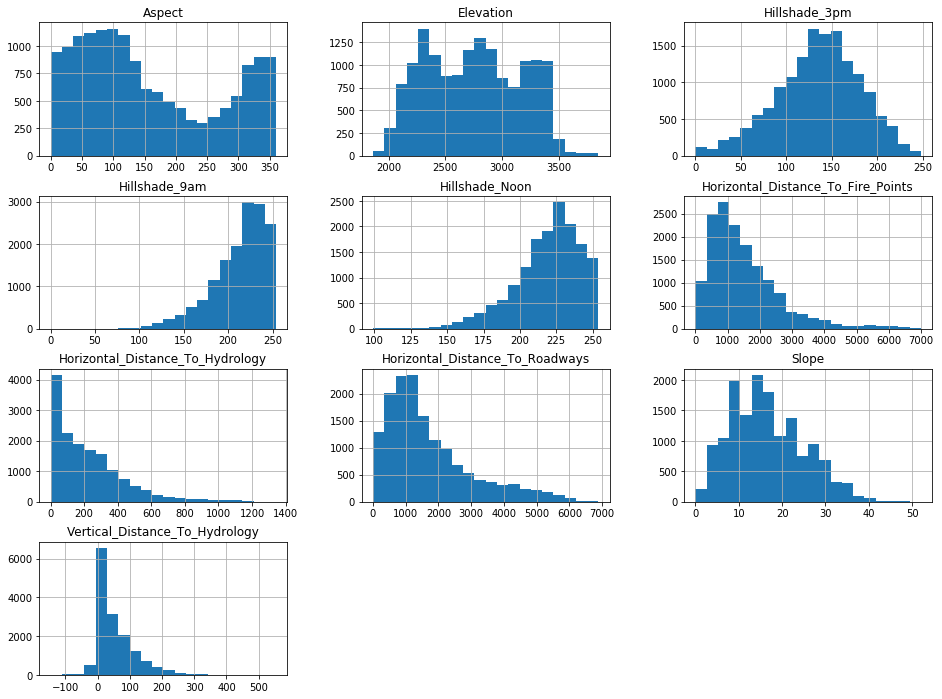

In [8]:
df_train[num_features].hist(figsize=(16,12), bins=20)
plt.show()

#### skew

- values close to 0 show less skew

- several features in Soil_Type show a large skew. Hence, some algorithms may benefit if skew corrected

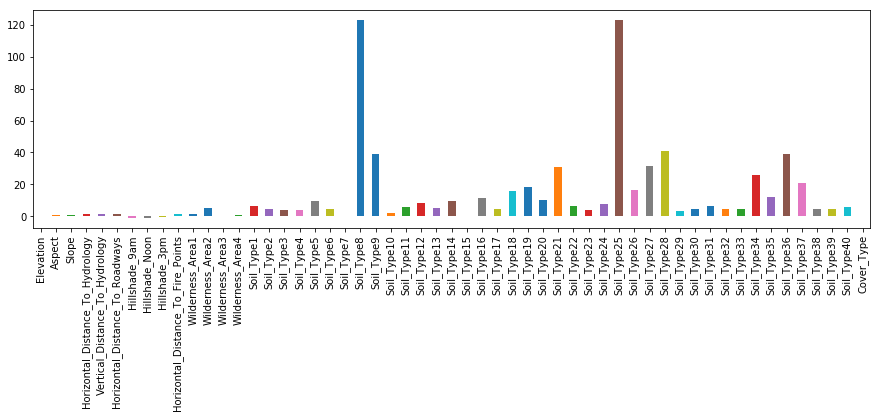

In [9]:
df_train.skew().plot(kind='bar', figsize=(15,4))
plt.show()

#### class distribution

- all classes have the same number, no class-rebalancing is necessary

In [10]:
df_train.groupby('Cover_Type').size()

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

### 1.1 Correlations

- Correlation requires continuous data, ignore Wilderness_Area and Soil_Type here.

- strong correlation observed for following pairs, opportunity to reduce features

Hillshade_9am & Hillshade_3pm = -0.78
Horizontal_Distance_To_Hydrology & Vertical_Distance_To_Hydrology = 0.65
Aspect & Hillshade_3pm = 0.64
Hillshade_Noon & Hillshade_3pm = 0.61
Slope & Hillshade_Noon = -0.61
Aspect & Hillshade_9am = -0.59
Elevation & Horizontal_Distance_To_Roadways = 0.58


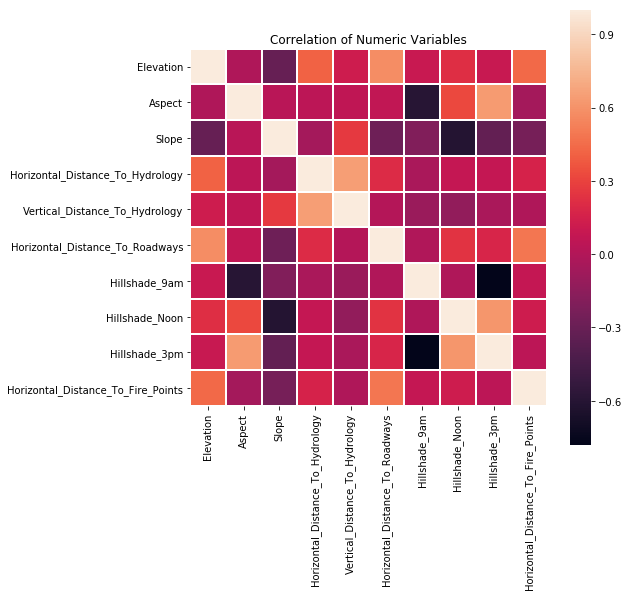

In [13]:
size = num_features.shape[0]         # size: 10 numeric features
num_data = df_train[num_features]    #  selecting numeric features

num_data_cor = num_data.corr()       # correlation matrix

cor_threshold = 0.5                  # threshold for selecting highly correlated features
num_data_cor_high = []               # list for pairs with cor > threshold

# search for highly correlated pairs
for i in range(0, size):
    for j in range(i+1, size):
        if abs(num_data_cor.iloc[i,j]) >= cor_threshold:                  
            num_data_cor_high.append([num_data_cor.iloc[i,j], i, j])  # store correlation
            
# sort to show high ones
num_data_cor_high_sorted = sorted(num_data_cor_high, key = lambda x: -abs(x[0]))

# print correlation and column names
for v, i, j in num_data_cor_high_sorted:
    print("{} & {} = {:.2f}".format(num_features[i], num_features[j], v))

# correlation heat map
fig, ax = plt.subplots(figsize=(8, 8))  
sns.heatmap(num_data_cor, square=True, linewidths=1)
plt.title('Correlation of Numeric Variables')
plt.show()

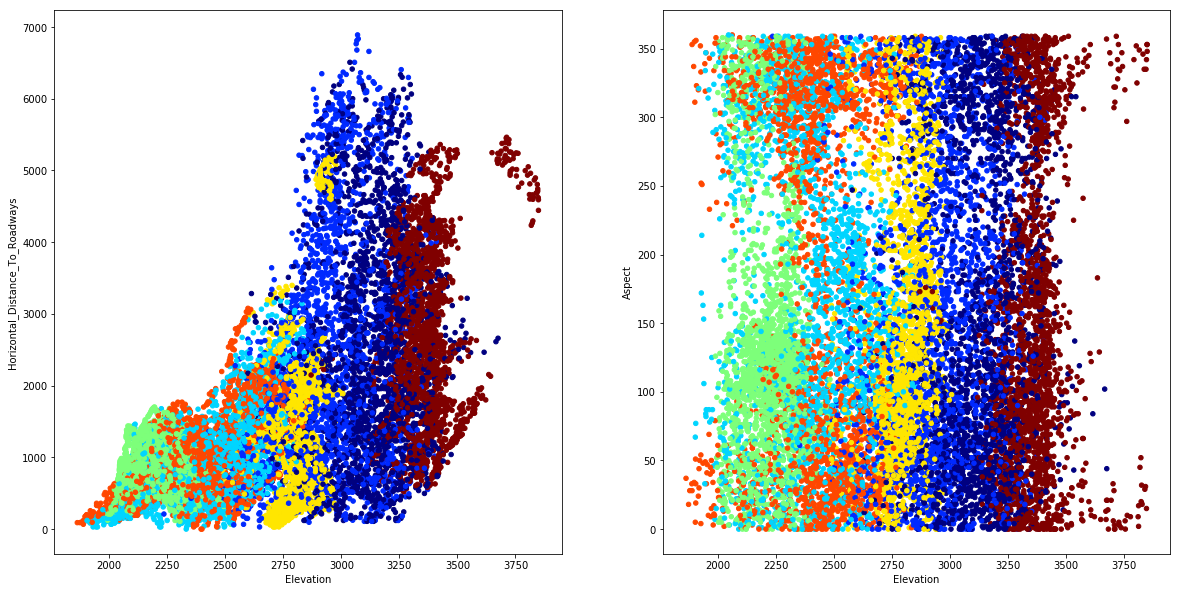

In [16]:
cmap = cm.jet

labels = df_train.Cover_Type

fig, axes = plt.subplots(1, 2, figsize=(20,10))

df_train.plot(kind='scatter', x='Elevation', y='Horizontal_Distance_To_Roadways',
              marker='o', c=labels, cmap=cmap, colorbar=False, ax=axes[0])

df_train.plot(kind='scatter', x='Elevation', y='Aspect', 
              marker='o', c=labels, cmap=cmap, colorbar=False, ax=axes[1])

plt.show()

Wilderness_Area1 3597
Wilderness_Area2 499
Wilderness_Area3 6349
Wilderness_Area4 4675


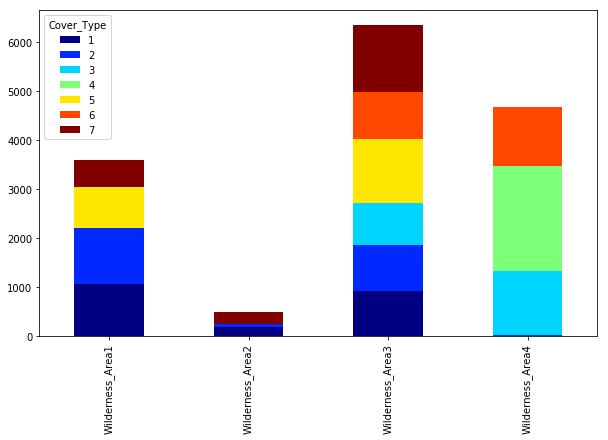

In [17]:
col_names = df_train.columns.tolist()

A = np.array(col_names)

soil_types = [item for item in A if "Soil" in item]
wilderness_areas = [item for item in A if "Wilderness_Area" in item]

# Which wilderness_area support which cover_types?

for wilderness_area in wilderness_areas: print(wilderness_area, df_train[wilderness_area].sum())

wild_areas_sum = df_train[wilderness_areas].groupby(df_train['Cover_Type']).sum()
wild_areas_sum.T.plot(kind='bar', stacked=True, figsize=(10,6), cmap='jet')
plt.show()    

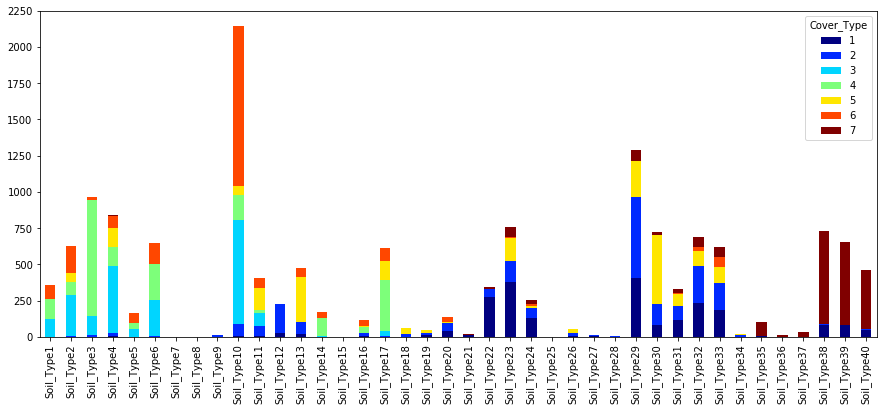

In [18]:
# Which soil_types support which cover_types?

# for soil_type in soil_types: print (soil_type, df_train[soil_type].sum())

types_sum = df_train[soil_types].groupby(df_train['Cover_Type']).sum()
types_sum.T.plot(kind='bar', stacked=True, figsize=(15,6), cmap='jet')
plt.show()

## 2. Modeling Strategies

### 2.1 Logistic Regression (PKB)

In [36]:
continuous = ['Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]
discrete = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'
]
predictors = continuous + discrete

target = ['Cover_Type']

train_set, dev_set = cross_validation.train_test_split(df_train,test_size=.25, random_state = 42)
X_train = train_set[predictors]
X_dev = dev_set[predictors]
y_train = train_set[target]
y_dev = dev_set[target]

In [ ]:
#fit log model
lr = LogisticRegression(penalty='l2')
#c values to be tested
c = {'C': [0.01, 0.1, 0.5, 1.0, 2.0]}

gs = GridSearchCV(estimator=lr, param_grid=c)
gs.fit(X_train, y_train.values.ravel())
f1 = metrics.f1_score(y_dev, gs.predict(X_dev), average='weighted')

print('Best C:', gs.best_estimator_.C)
print('Accuracy:', gs.best_score_ )
print('F1:', f1)

In [11]:
lr = LogisticRegression(penalty='l2', C=0.1)
lr.fit(X_train, y_train.values.ravel())

cm = confusion_matrix(y_dev, lr.predict(X_dev))
print (cm)

[[254  72   1   0  37   3  53]
 [ 70 208   6   0  65  16   3]
 [  0   7 195  59  27 139   0]
 [  0   0  27 365   0  32   0]
 [ 13  58  38   0 299  16   1]
 [  0  17  73  39  43 212   0]
 [ 37   2   4   0   2   0 342]]


In [ ]:
lr = LogisticRegression(penalty='l2', C=0.1)
lr.fit(df[predictors], df[target].values.ravel())

pred = lr.predict(df_test[predictors])
ID = df_test.Id

data_out = []
for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})
    
import csv
with open('base_log_model.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

0.3825575015358379
47


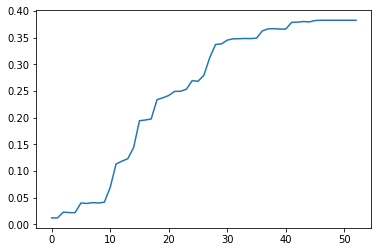

In [34]:
#PCA

def best_components(n_features):
    pca = PCA(n_components=n_features)
    X_transformed = pca.fit_transform(X_train)
    lr = LinearRegression()
    lr.fit(X_transformed, y_train)
    return lr.score(pca.transform(X_dev), y_dev)

out = [best_components(i) for i in range(1, 54)]

plt.plot(out)
print(np.max(out))
print(np.argmax(out))

In [24]:
pca = PCA(n_components= 47)
X_transformed = pca.fit_transform(X_train)
#fit log model
lr = LogisticRegression(penalty='l2')
#c values to be tested
c = {'C': [10.0, 11.0, 12.0, 13.0, 14.0]}

gs = GridSearchCV(estimator=lr, param_grid=c)
gs.fit(X_transformed, y_train.values.ravel())
f1 = metrics.f1_score(y_dev, gs.predict(pca.transform(X_dev)), average='weighted')

print('Best C:', gs.best_estimator_.C)
print('Accuracy:', gs.best_score_ )
print('F1:', f1)
#gave 11 but didnt like it C=2 works best

Best C: 14.0
Accuracy: 0.672663139329806
F1: 0.6708173433034006


In [ ]:
# df_test['Mean Hillshade'] = df_test[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
# df_test['log_elavation'] = np.log(df_test['Elevation'])

pca = PCA(n_components= 47)
X_transformed = pca.fit_transform(df[predictors])
lr = LogisticRegression(penalty='l2', C=2.0)
lr.fit(X_transformed, df[target].values.ravel())

pred = lr.predict(pca.transform(df_test[predictors]))
ID = df_test.Id

data_out = []

for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})
    
fout = open('logistic_pca.csv', 'wt') # <- best so far! 56% C=2.0 w/ PCA = 47 
cout = csv.DictWriter(fout, ['ID','Cover_Type'])
cout.writeheader()
cout.writerows(data_out)
fout.close()

### 2.2 KNN (ZY)

In [4]:
df_all_train = pd.read_csv('train.csv')
df_all_test = pd.read_csv('test.csv')

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_all_train, random_state=1)

In [5]:
feature_columns = df_all_test.columns

X_all_train = df_all_train[feature_columns]
X_all_test = df_all_test[feature_columns]

X_train = df_train[feature_columns]
X_test = df_test[feature_columns]

y_all_train = df_all_train.Cover_Type
y_train = df_train.Cover_Type
y_test = df_test.Cover_Type

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
#ss = StandardScaler()
#X_scaled = ss.fit_transform(X)
from sklearn.pipeline import Pipeline

def get_knn3_accuracy(pca_num, knn_num):
    ss3 = StandardScaler()
    knn3 = KNeighborsClassifier(n_neighbors=knn_num)
    pipe3 = Pipeline(steps = [
        ('ss', ss3),
        ('knn', knn3)])
    pipe3.fit(X_train, y_train)
    y_hat_test = pipe3.predict(X_test)
    acc_test = np.round(sum(y_hat_test == y_test)/float(len(y_test)),4)
    return acc_test

In [ ]:
# Run the grid and create a dataframe with the results
knn3_comp = []
mod3_accu = []

# Run the grid

for knn_num in [1, 2, 5, 10, 15, 20, 25]:
    knn3_comp.append(knn_num)
    m_acc = get_knn2_accuracy(pca_num, knn_num)
    mod3_accu.append(m_acc)
    #print pca_num, knn_num, m_acc

# Create a dataframe for the results from the lists            
knn3_tuples = list(zip(knn3_comp, mod3_accu))
knn3df = pd.DataFrame(knn3_tuples, columns=['KNN_comp', 'mod_accuracy'])

print(knn3df)

In [7]:
# Using X_all_train to train KNN with n = 1, 2, 5, 10, 15, 20
# predict X_all_test, write to csv, submit to Kaggle for evaluation

knn_num = 1

ss3 = StandardScaler()
knn3 = KNeighborsClassifier(n_neighbors=knn_num)
pipe3 = Pipeline(steps = [
    ('ss', ss3),
    ('knn', knn3)])
pipe3.fit(X_all_train, y_all_train)

pred = pipe3.predict(df_all_test)
ID = df_all_test.Id

data_out = []
for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})

import csv
with open('test_submission_knn3_ss_'+'_n_' + str(knn_num) + '.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

Summary of best knn

knn=1, score = 0.47992

knn=2, score = 0.49291

knn=5, score = 0.47094

knn=10, score = 0.4626

knn=20, score = 0.45203

### 2.3 SVM (ZY)

### 2.4 Random Forest (Zach)

- Pre-processing: Collapse one-hot coded categorical variables into single categorical variables (one for all soil types and another for all wilderness areas)

In [12]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# Import train data
df=pd.read_csv('train.csv', sep=',')

# Import test data
df_test = pd.read_csv('test.csv')

# Specify predictor cols and target col
predictors = df.columns[0:-1]
target = df.columns[-1]

# Create Train / Test split
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(df[predictors], df[target], random_state=2)

In [10]:
## Create a single Wilderness_Area column
# Make a copy of the original df dataframe
df_trim = df

# Function to create the values for the Wilderness_Area column
def wild_area(row):
    if row['Wilderness_Area1'] == 1:
        return 1
    if row['Wilderness_Area2'] == 1:
        return 2
    if row['Wilderness_Area3'] == 1:
        return 3
    if row['Wilderness_Area4'] == 1: 
        return 4

# Create the Wilderness_Area column
df_trim['Wilderness_Area'] = df_trim.apply(lambda row: wild_area(row), axis = 1)

## Create a single Soil_Type column
# Function to create the values for the Soil_Type column 
def soil_type(row):
    for i in range(15,55):
        if row[i] == 1:
            return i - 14
        
# Create the Soil_Type column
df_trim['Soil_Type'] = df_trim.apply(lambda row: soil_type(row), axis = 1)

# Drop old Soil_TypeXX and Wilderness_AreaX cols
df_trim = df_trim.drop(labels = df_trim.columns[15:55], axis = 1)
df_trim = df_trim.drop(labels = df.columns[11:15], axis = 1)

# Re-Create Train / Test split
target = df_trim.columns[-3]
predictors = df_trim.columns[~df_trim.columns.isin([target])]
X_train, X_dev, y_train, y_dev = train_test_split(df_trim[predictors], df_trim[target], random_state=2)

- Use RandomizedSearchCV() to narrow the optimal hyperparameter values to a manageable range, then use GridSearchCV() to drill down to specific optimal hyperparameter values

In [13]:
# num of trees
n_estimators = [int(x) for x in np.linspace(100, 500, 5)]

# num of features considered at each split
max_features = ['auto', 'sqrt', 0.5]

# max num of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 11)]

# min num of samples required to split a node
min_samples_split = [2, 5, 10]

# min num of samples required at ea leaf node
min_samples_leaf = [1, 2, 4]

# method of selecting samples for training each tree
bootstrap = [True, False]

# create random grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

# use random grid to search for optimal hyperparameter ranges
# instantiate random forest model
rf = RandomForestClassifier()

# random search of hyperparams
rf_random = RandomizedSearchCV(estimator= rf, param_distributions= random_grid, n_iter = 100, cv= 3, random_state= 141, verbose= 2, n_jobs= -1)

# fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt', 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=141, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

- Compare accurace of base model with the accuracy of a model using the most optimal hyperparams identified by the random search.

In [21]:
# create function to evaluate different models
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = np.sum(predictions != test_labels)
    accuracy = np.mean(predictions == test_labels)
    print('Model Performance')
    print('Accuracy = {:.1%} \n\n'.format(accuracy))
    return accuracy

# compute accuracy for base model
base = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, random_state=121)
base.fit(X_train, y_train)
base_accuracy = evaluate(base, X_dev, y_dev)

# compute accuracy for tuned model w/best params from random search model
best_random = rf_random.best_estimator_
best_random_accuracy = evaluate(best_random, X_dev, y_dev)

Model Performance
Accuracy = 86.8% 


Model Performance
Accuracy = 88.0% 




- Now, with ranges of optimal hyperparam values from our random search, use grid search to find the most optimal individual hyperparam values.

In [20]:
# create grid search param
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 25],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 3],
    'n_estimators': [400, 450]
}

# create another base model
rf = RandomForestClassifier()

# instantiate grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3,
                          n_jobs = -1, verbose = 2)

# fit grid search to data
grid_search.fit(X_train, y_train)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_dev, y_dev)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   51.4s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   53.6s finished


Model Performance
Accuracy = 88.3% 




Error Analysis Methods:


### 2.5 AdaBoost (ZY)

## 3. Conclusion (Patrick)